# Random forest feature selection
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Feature importance](#Feature-importance)

In [2]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [3]:
import argparse
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold

import composition as comp
import composition.analysis.plotting as plotting

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = defaultdict()
for i, composition in enumerate(['light', 'heavy', 'total']):
    color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

/home/jbourbeau/cr-composition/composition/load_dataframe.py:88: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))
/home/jbourbeau/cr-composition/composition/load_dataframe.py:89: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_1_30'] = np.nan_to_num(np.log10(df['NHits_1_30']))


training features = ['lap_log_energy' 'InIce_log_charge_1_30' 'lap_cos_zenith'
 'log_NChannels_1_30' 'log_s125' 'StationDensity' 'charge_nchannels_ratio'
 'charge_nhits_ratio' 'stationdensity_charge_ratio' 'nchannels_nhits_ratio'
 'stationdensity_nchannels_ratio' 'stationdensity_nhits_ratio'
 'lap_likelihood' 'log_NHits_1_30' 'log_s50' 'log_s80' 'log_s180'
 'log_s250' 'log_s500']
number training events = 145932
number testing events = 62543


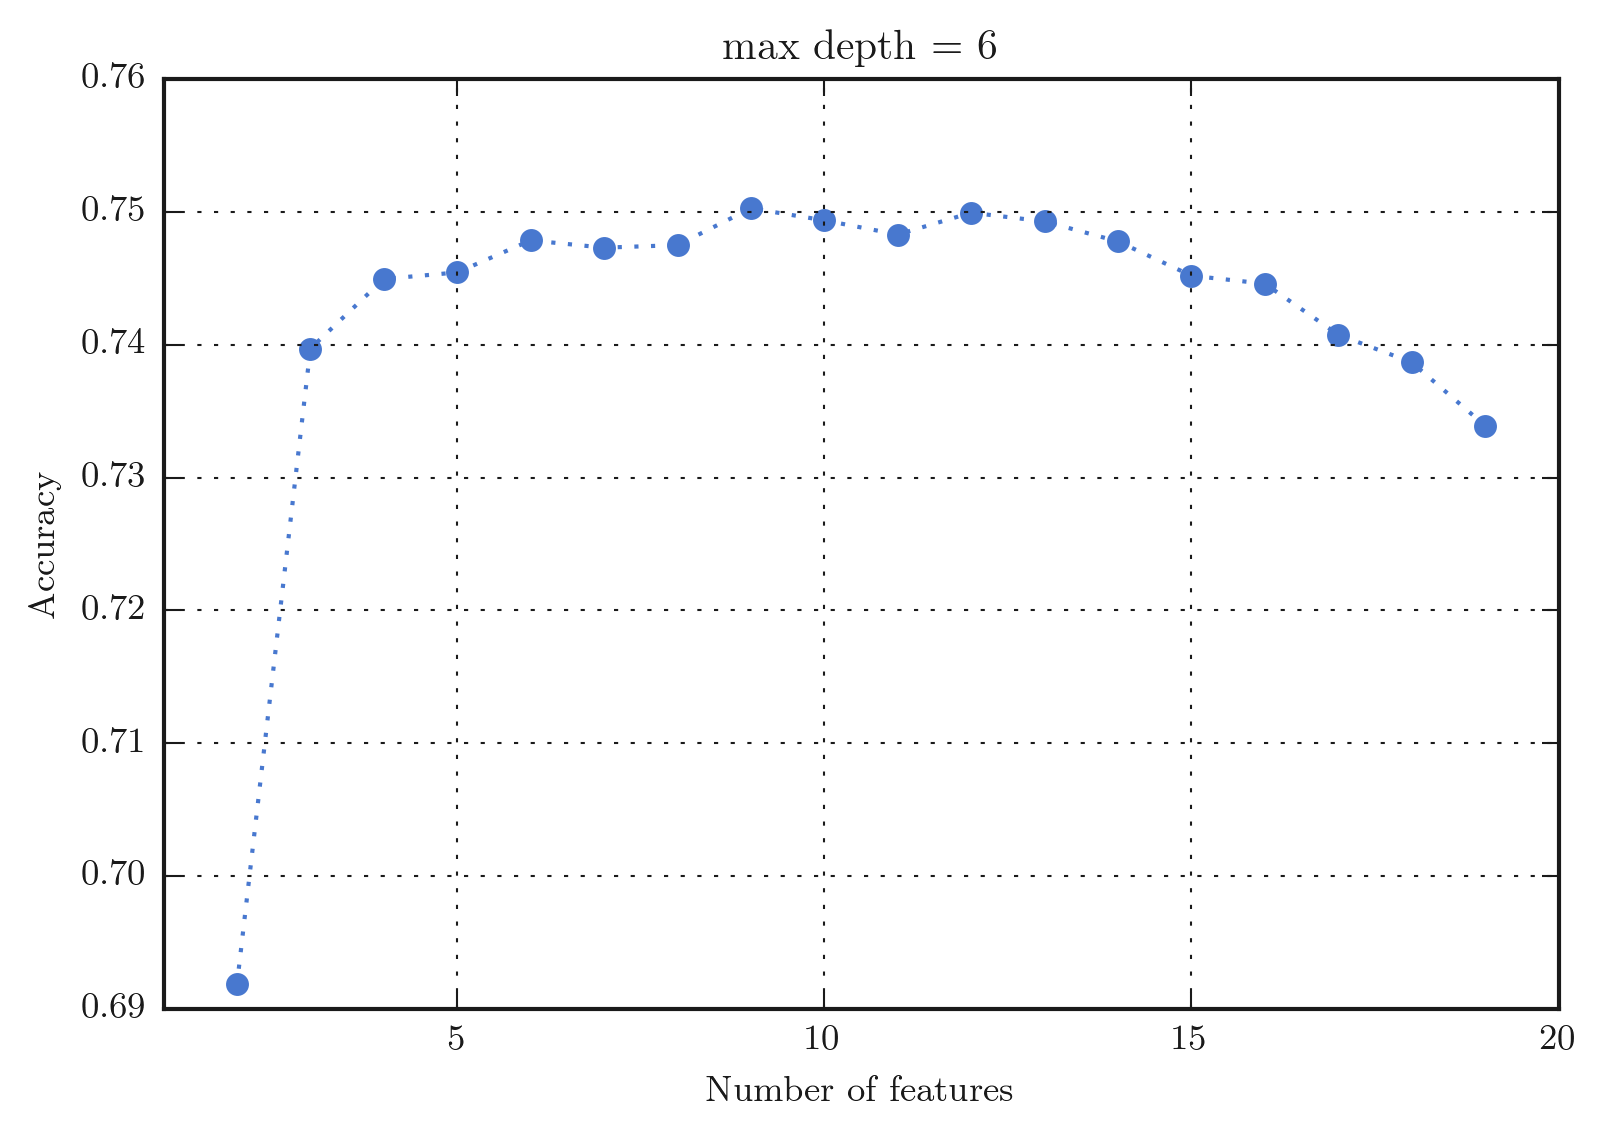

In [4]:
df, cut_dict = comp.load_dataframe(type_='sim', config='IT73', return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

# feature_list, feature_labels = comp.get_training_features()
feature_list = np.array(['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith',
                         'log_NChannels_1_30', 'log_s125', 'StationDensity',
                         'charge_nchannels_ratio', 'charge_nhits_ratio',
                         'stationdensity_charge_ratio', 'nchannels_nhits_ratio', 
                         'stationdensity_nchannels_ratio', 'stationdensity_nhits_ratio',
                         'lap_likelihood', 'log_NHits_1_30', 'log_s50', 'log_s80', 
                         'log_s180', 'log_s250', 'log_s500'])
label_dict = {'reco_log_energy': '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$',
              'lap_log_energy': '$\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$',
              'log_s50': '$\log_{10}(S_{\mathrm{50}})$',
              'log_s80': '$\log_{10}(S_{\mathrm{80}})$',
              'log_s125': '$\log_{10}(S_{\mathrm{125}})$',
              'log_s180': '$\log_{10}(S_{\mathrm{180}})$',
              'log_s250': '$\log_{10}(S_{\mathrm{250}})$',
              'log_s500': '$\log_{10}(S_{\mathrm{500}})$',
              'lap_likelihood': '$r\log_{10}(l)$',
              'InIce_charge_1_30': 'InIce charge (top 50\%)',
              'InIce_log_charge_1_30': '$\log_{10}$(InIce charge (top 50\%))',
              'lap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHlap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHLF_cos_zenith': '$\cos(\\theta_{\mathrm{LLH+COG}})$',
              'lap_chi2': '$\chi^2_{\mathrm{Lap}}/\mathrm{n.d.f}$',
              'NChannels_1_30': 'NChannels (top 50\%)',
              'log_NChannels_1_30' : '$\log_{10}$(NChannels (top 50\%))',
              'StationDensity': 'StationDensity',
              'charge_nchannels_ratio': 'Charge/NChannels',
              'stationdensity_charge_ratio': 'StationDensity/Charge', 
              'NHits_1_30': 'NHits',
              'log_NHits_1_30': '$\log_{10}$(NHits (top 50\%))',
              'charge_nhits_ratio': 'Charge/NHits',
              'nchannels_nhits_ratio': 'NChannels/NHits', 
              'stationdensity_nchannels_ratio': 'StationDensity/NChannels',
              'stationdensity_nhits_ratio': 'StationDensity/NHits'
              }
feature_labels = np.array([label_dict[feature] for feature in feature_list])

print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, comp_class=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

fig, ax = plt.subplots()
pipeline = comp.get_pipeline('RF')
sbs = comp.analysis.SBS(pipeline, k_features=2)
sbs.fit(X_train, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

ax.plot(k_feat, sbs.scores_, marker='.', linestyle=':')
# plt.ylim([0.5, 1.1])
ax.set_xlim([sorted(k_feat)[0]-1, sorted(k_feat)[-1]+1])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of features')
ax.set_title('max depth = {}'.format(pipeline.get_params()['classifier__max_depth']))
ax.grid()
plt.show()

In [5]:
print(sbs.subsets_)
print(len(feature_list))
gen = (feature_list[i] for i in sbs.subsets_)
for i in sbs.subsets_:
    print(', '.join(feature_list[np.array(i)]))
    print('\n')

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18), (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18), (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18), (0, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18), (0, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18), (0, 2, 3, 4, 5, 7, 9, 12, 13, 14, 15, 16, 17, 18), (0, 2, 3, 4, 5, 9, 12, 13, 14, 15, 16, 17, 18), (0, 2, 3, 4, 5, 9, 12, 13, 14, 15, 17, 18), (0, 2, 3, 5, 9, 12, 13, 14, 15, 17, 18), (2, 3, 5, 9, 12, 13, 14, 15, 17, 18), (2, 3, 9, 12, 13, 14, 15, 17, 18), (2, 3, 9, 12, 13, 14, 15, 18), (2, 3, 9, 13, 14, 15, 18), (2, 3, 9, 14, 15, 18), (2, 3, 9, 14, 18), (2, 3, 9, 14), (3, 9, 14), (3, 14)]
19
lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio, charge_nhits_ratio, stationdensity_charge_ratio, nchannels_nhits_ratio, stationdensity_nchannels_ratio, stationdensity_nhits_ratio, lap_likelihood, log_NHits_1_30, log_s50

training features = ['lap_log_energy' 'InIce_log_charge_1_30' 'lap_cos_zenith'
 'log_NChannels_1_30' 'log_s125' 'StationDensity' 'charge_nchannels_ratio'
 'charge_nhits_ratio' 'stationdensity_charge_ratio' 'nchannels_nhits_ratio'
 'stationdensity_nchannels_ratio' 'stationdensity_nhits_ratio'
 'lap_likelihood' 'log_NHits_1_30' 'log_s50' 'log_s80' 'log_s180'
 'log_s250' 'log_s500']
number training events = 145932
number testing events = 62543
max_depth = 4
lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio, charge_nhits_ratio, stationdensity_charge_ratio, nchannels_nhits_ratio, stationdensity_nchannels_ratio, stationdensity_nhits_ratio, lap_likelihood, log_NHits_1_30, log_s50, log_s80, log_s180, log_s250, log_s500


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio, charge_nhits_ratio, nchannels_nhits_ratio, stationdensity_nchannels_ratio, sta

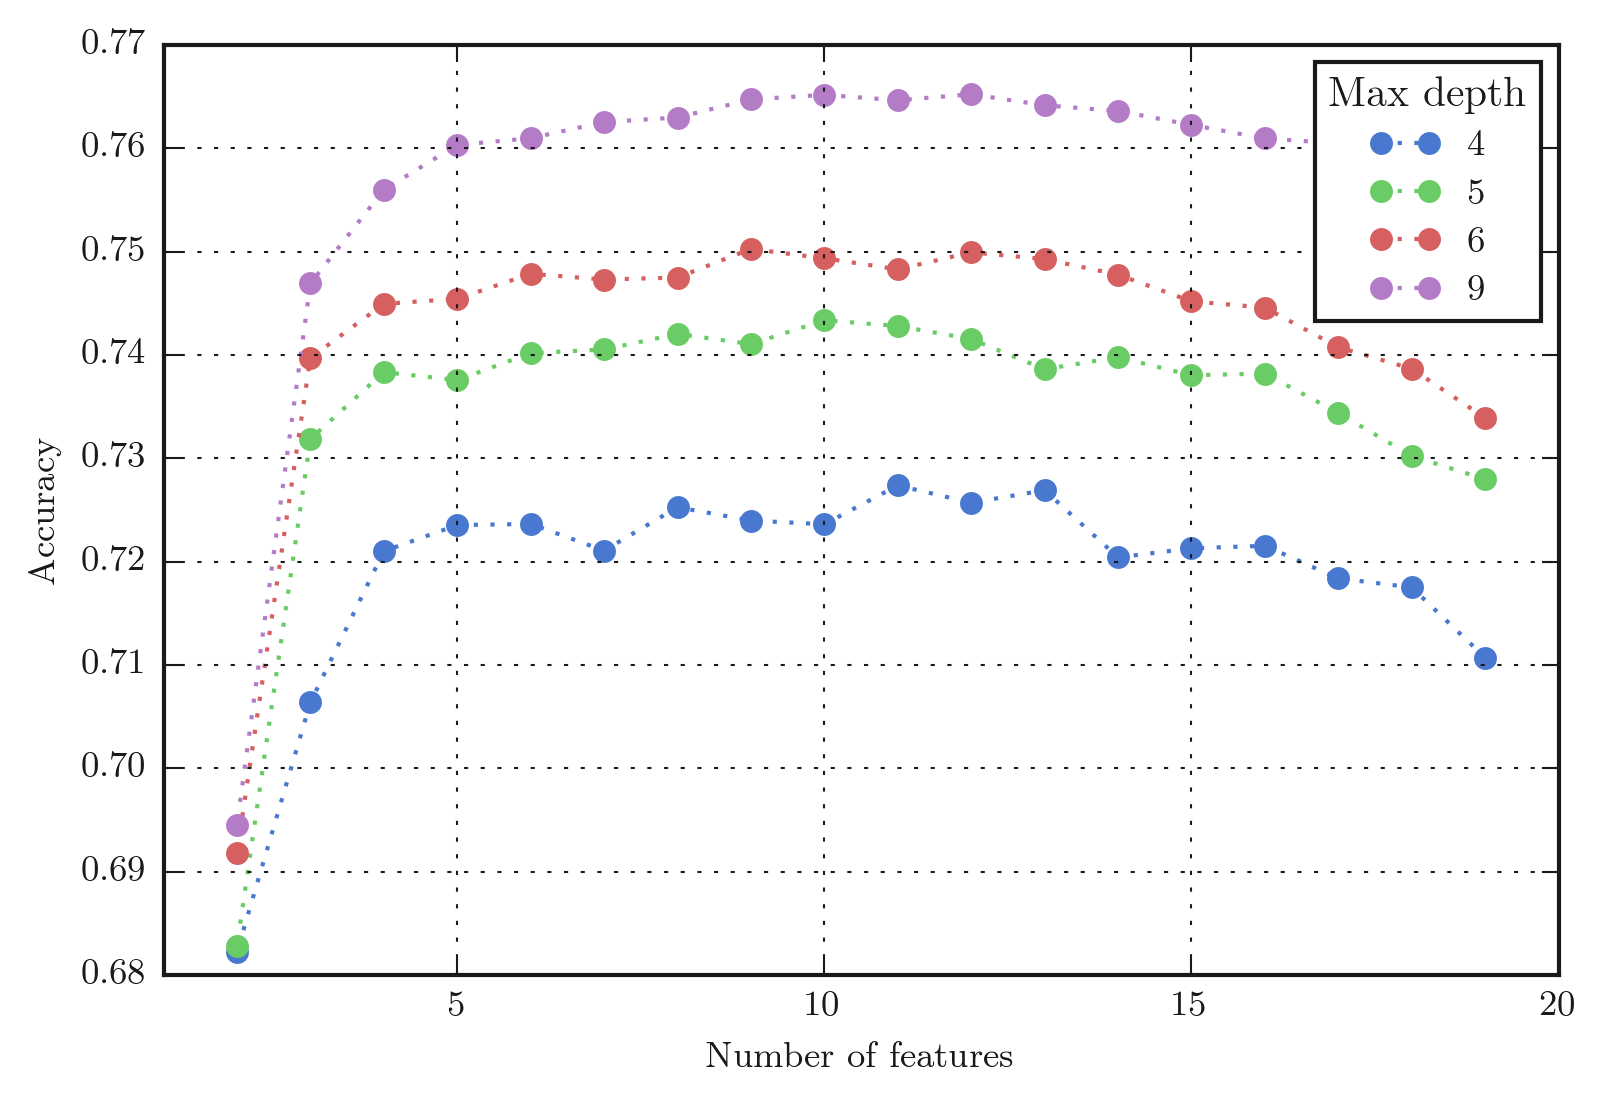

In [6]:
df, cut_dict = comp.load_dataframe(type_='sim', config='IT73', return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

# feature_list, feature_labels = comp.get_training_features()
feature_list = np.array(['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith',
                         'log_NChannels_1_30', 'log_s125', 'StationDensity',
                         'charge_nchannels_ratio', 'charge_nhits_ratio',
                         'stationdensity_charge_ratio', 'nchannels_nhits_ratio', 
                         'stationdensity_nchannels_ratio', 'stationdensity_nhits_ratio',
                         'lap_likelihood', 'log_NHits_1_30', 'log_s50', 'log_s80', 
                         'log_s180', 'log_s250', 'log_s500'])
label_dict = {'reco_log_energy': '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$',
              'lap_log_energy': '$\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$',
              'log_s50': '$\log_{10}(S_{\mathrm{50}})$',
              'log_s80': '$\log_{10}(S_{\mathrm{80}})$',
              'log_s125': '$\log_{10}(S_{\mathrm{125}})$',
              'log_s180': '$\log_{10}(S_{\mathrm{180}})$',
              'log_s250': '$\log_{10}(S_{\mathrm{250}})$',
              'log_s500': '$\log_{10}(S_{\mathrm{500}})$',
              'lap_likelihood': '$r\log_{10}(l)$',
              'InIce_charge_1_30': 'InIce charge (top 50\%)',
              'InIce_log_charge_1_30': '$\log_{10}$(InIce charge (top 50\%))',
              'lap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHlap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHLF_cos_zenith': '$\cos(\\theta_{\mathrm{LLH+COG}})$',
              'lap_chi2': '$\chi^2_{\mathrm{Lap}}/\mathrm{n.d.f}$',
              'NChannels_1_30': 'NChannels (top 50\%)',
              'log_NChannels_1_30' : '$\log_{10}$(NChannels (top 50\%))',
              'StationDensity': 'StationDensity',
              'charge_nchannels_ratio': 'Charge/NChannels',
              'stationdensity_charge_ratio': 'StationDensity/Charge', 
              'NHits_1_30': 'NHits',
              'log_NHits_1_30': '$\log_{10}$(NHits (top 50\%))',
              'charge_nhits_ratio': 'Charge/NHits',
              'nchannels_nhits_ratio': 'NChannels/NHits', 
              'stationdensity_nchannels_ratio': 'StationDensity/NChannels',
              'stationdensity_nhits_ratio': 'StationDensity/NHits'
              }
feature_labels = np.array([label_dict[feature] for feature in feature_list])

print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, comp_class=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

fig, ax = plt.subplots()
for max_depth in [4, 5, 6, 9]:
    print('max_depth = {}'.format(max_depth))
    pipeline = comp.get_pipeline('RF')
    params = {'classifier__max_depth': max_depth}
    pipeline.set_params(**params)
    sbs = comp.analysis.SBS(pipeline, k_features=2)
    sbs.fit(X_train, y_train)

    # plotting performance of feature subsets
    k_feat = [len(k) for k in sbs.subsets_]
    gen = (feature_list[i] for i in sbs.subsets_)
    for i in sbs.subsets_:
        print(', '.join(feature_list[np.array(i)]))
        print('\n')

    ax.plot(k_feat, sbs.scores_, marker='.', linestyle=':', label=max_depth)
    # plt.ylim([0.5, 1.1])
ax.set_xlim([sorted(k_feat)[0]-1, sorted(k_feat)[-1]+1])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of features')
# ax.set_title('max depth = {}'.format(max_depth))
ax.grid()
plt.legend(title='Max depth')
plt.show()

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))
/home/jbourbeau/cr-composition/composition/load_sim.py:110: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_1_30'] = np.nan_to_num(np.log10(df['NHits_1_30']))


training features = ['lap_log_energy' 'InIce_log_charge_1_30' 'lap_cos_zenith'
 'log_NChannels_1_30' 'log_s125' 'StationDensity' 'charge_nchannels_ratio'
 'charge_nhits_ratio' 'stationdensity_charge_ratio' 'nchannels_nhits_ratio'
 'stationdensity_nchannels_ratio' 'stationdensity_nhits_ratio'
 'lap_likelihood' 'log_NHits_1_30']
number training events = 145932
number testing events = 62543
max_depth = 4
lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio, charge_nhits_ratio, stationdensity_charge_ratio, nchannels_nhits_ratio, stationdensity_nchannels_ratio, stationdensity_nhits_ratio, lap_likelihood, log_NHits_1_30


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, charge_nchannels_ratio, charge_nhits_ratio, stationdensity_charge_ratio, nchannels_nhits_ratio, stationdensity_nchannels_ratio, stationdensity_nhits_ratio, lap_likelihood, log_NHits_1_30


lap_log_energy, lap_cos_zenith,

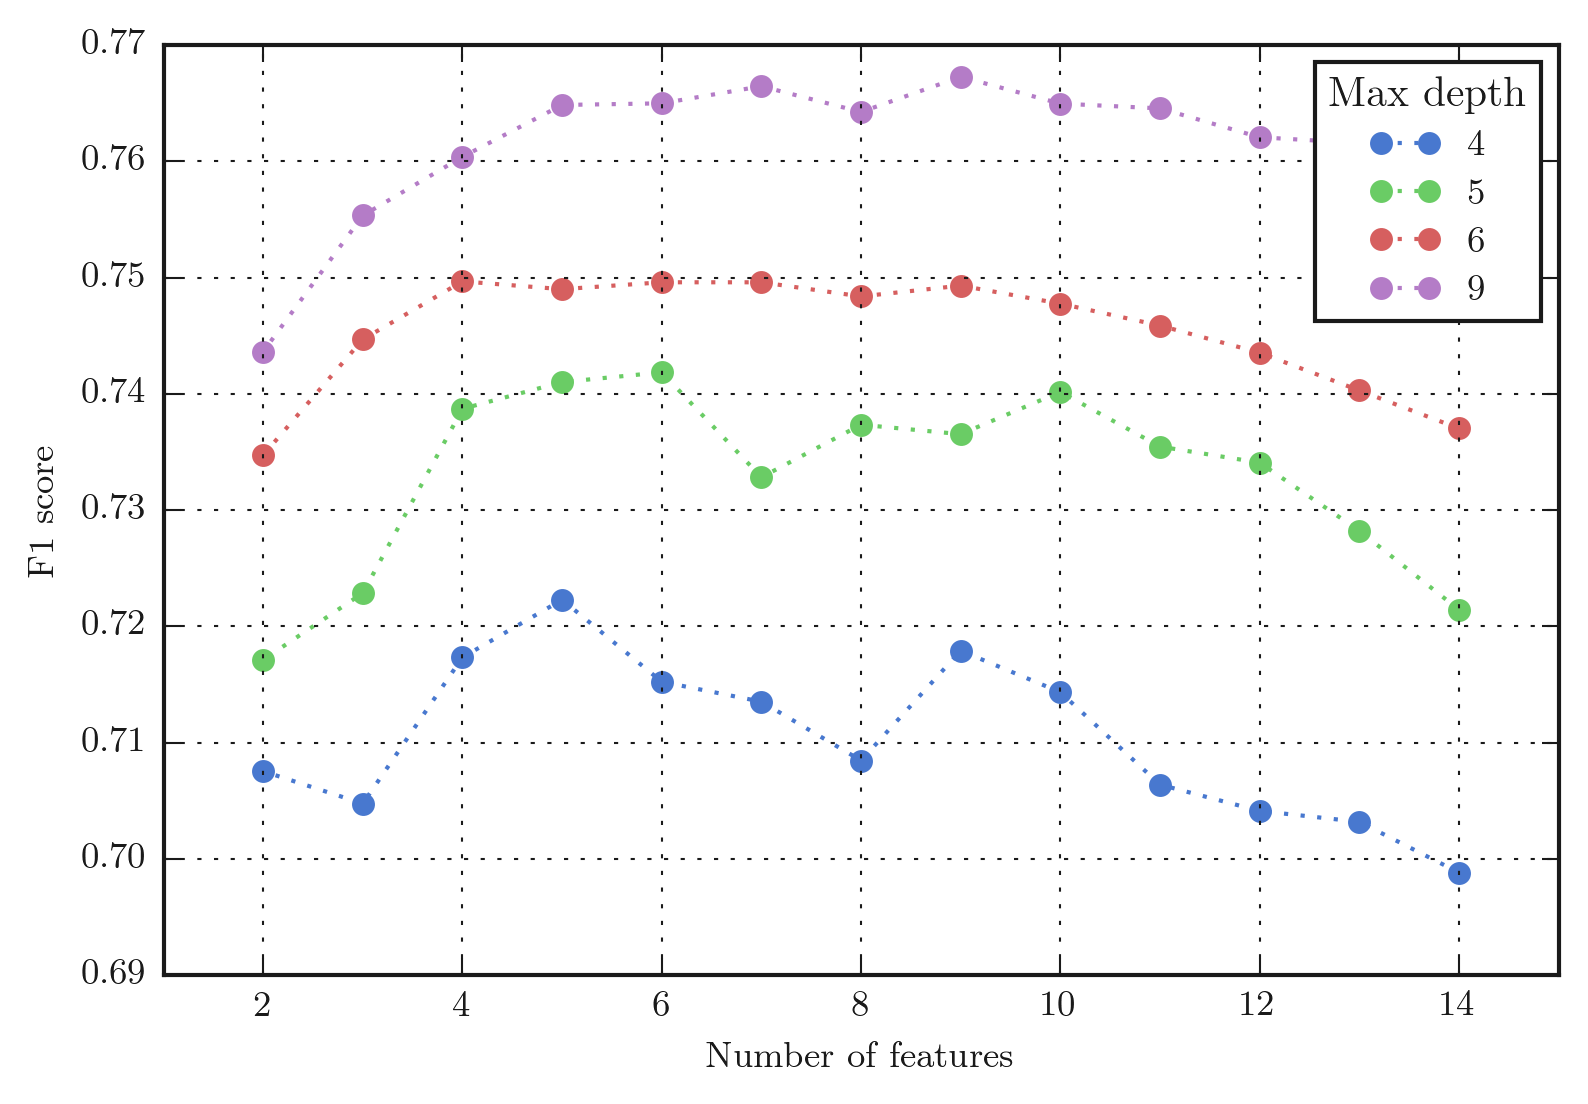

In [3]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

# feature_list, feature_labels = comp.get_training_features()
feature_list = np.array(['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith',
                         'log_NChannels_1_30', 'log_s125', 'StationDensity',
                         'charge_nchannels_ratio', 'charge_nhits_ratio',
                         'stationdensity_charge_ratio', 'nchannels_nhits_ratio', 
                         'stationdensity_nchannels_ratio', 'stationdensity_nhits_ratio',
                         'lap_likelihood', 'log_NHits_1_30', ])
label_dict = {'reco_log_energy': '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$',
              'lap_log_energy': '$\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$',
              'log_s125': '$\log_{10}(S_{\mathrm{125}})$',
              'lap_likelihood': '$r\log_{10}(l)$',
              'InIce_charge_1_30': 'InIce charge (top 50\%)',
              'InIce_log_charge_1_30': '$\log_{10}$(InIce charge (top 50\%))',
              'lap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHlap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHLF_cos_zenith': '$\cos(\\theta_{\mathrm{LLH+COG}})$',
              'lap_chi2': '$\chi^2_{\mathrm{Lap}}/\mathrm{n.d.f}$',
              'NChannels_1_30': 'NChannels (top 50\%)',
              'log_NChannels_1_30' : '$\log_{10}$(NChannels (top 50\%))',
              'StationDensity': 'StationDensity',
              'charge_nchannels_ratio': 'Charge/NChannels',
              'stationdensity_charge_ratio': 'StationDensity/Charge', 
              'NHits_1_30': 'NHits',
              'log_NHits_1_30': '$\log_{10}$(NHits (top 50\%))',
              'charge_nhits_ratio': 'Charge/NHits',
              'nchannels_nhits_ratio': 'NChannels/NHits', 
              'stationdensity_nchannels_ratio': 'StationDensity/NChannels',
              'stationdensity_nhits_ratio': 'StationDensity/NHits'
              }
feature_labels = np.array([label_dict[feature] for feature in feature_list])

print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, comp_class=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

fig, ax = plt.subplots()
for max_depth in [4, 5, 6, 9]:
    print('max_depth = {}'.format(max_depth))
    pipeline = comp.get_pipeline('RF')
    params = {'classifier__max_depth': max_depth}
    pipeline.set_params(**params)
    sbs = comp.analysis.SBS(pipeline, k_features=2, scoring=f1_score)
    sbs.fit(X_train, y_train)

    # plotting performance of feature subsets
    k_feat = [len(k) for k in sbs.subsets_]
    gen = (feature_list[i] for i in sbs.subsets_)
    for i in sbs.subsets_:
        print(', '.join(feature_list[np.array(i)]))
        print('\n')

    ax.plot(k_feat, sbs.scores_, marker='.', linestyle=':', label=max_depth)
    # plt.ylim([0.5, 1.1])
ax.set_xlim([sorted(k_feat)[0]-1, sorted(k_feat)[-1]+1])
ax.set_ylabel('F1 score')
ax.set_xlabel('Number of features')
# ax.set_title('max depth = {}'.format(max_depth))
ax.grid()
plt.legend(title='Max depth')
plt.show()

training features = ['lap_log_energy' 'InIce_log_charge_1_30' 'lap_cos_zenith'
 'log_NChannels_1_30' 'log_s125' 'StationDensity' 'charge_nchannels_ratio'
 'stationdensity_charge_ratio' 'lap_likelihood']
number training events = 145932
number testing events = 62543
max_depth = 3


KeyboardInterrupt: 

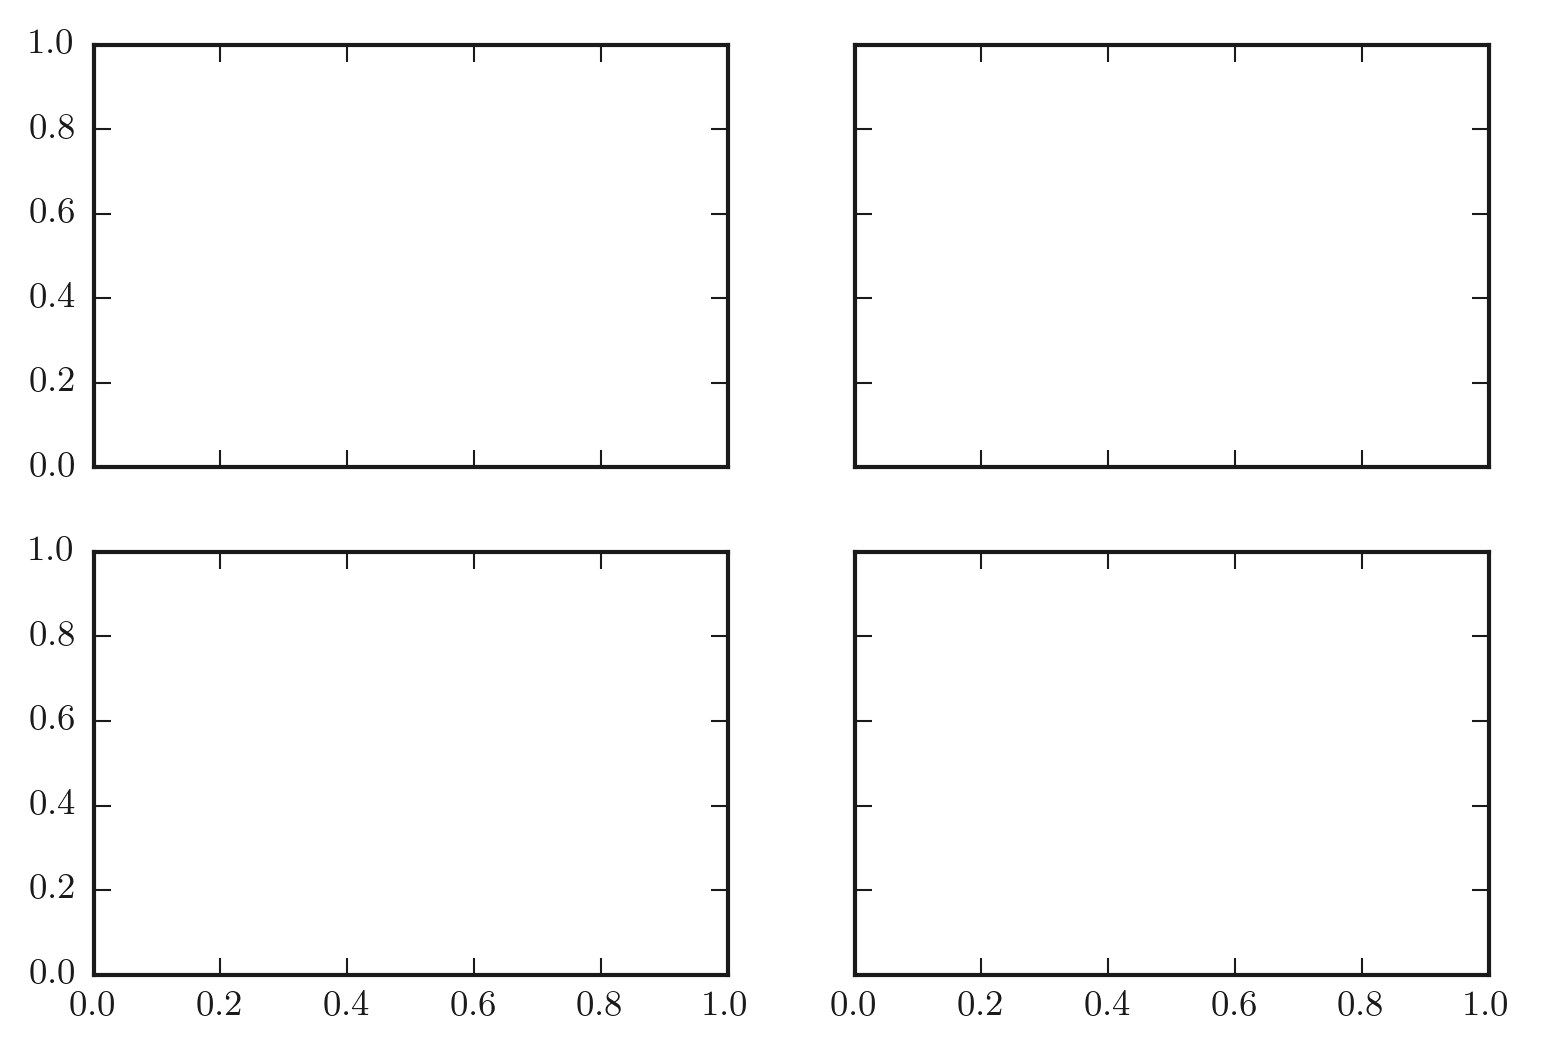

In [5]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

# feature_list, feature_labels = comp.get_training_features()
feature_list = np.array(['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith',
                         'log_NChannels_1_30', 'log_s125', 'StationDensity', 'charge_nchannels_ratio',
                         'stationdensity_charge_ratio', 'lap_likelihood'])
label_dict = {'reco_log_energy': '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$',
              'lap_log_energy': '$\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$',
              'log_s125': '$\log_{10}(S_{\mathrm{125}})$',
              'lap_likelihood': '$r\log_{10}(l)$',
              'InIce_charge_1_30': 'InIce charge (top 50\%)',
              'InIce_log_charge_1_30': '$\log_{10}$(InIce charge (top 50\%))',
              'lap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHlap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHLF_cos_zenith': '$\cos(\\theta_{\mathrm{LLH+COG}})$',
              'lap_chi2': '$\chi^2_{\mathrm{Lap}}/\mathrm{n.d.f}$',
              'NChannels_1_30': 'NChannels (top 50\%)',
              'log_NChannels_1_30' : '$\log_{10}$(NChannels (top 50\%))',
              'StationDensity': 'StationDensity',
              'charge_nchannels_ratio': 'Charge/NChannels',
              'stationdensity_charge_ratio': 'StationDensity/Charge', 
              }
feature_labels = np.array([label_dict[feature] for feature in feature_list])

print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
max_depth_list = [3, 5, 6, 7]
for max_depth, ax in zip(max_depth_list, axarr.flatten()):
    print('max_depth = {}'.format(max_depth))
    pipeline = comp.get_pipeline('RF')
    params = {'classifier__max_depth': max_depth}
    pipeline.set_params(**params)
    sbs = comp.analysis.SBS(pipeline, k_features=2)
    sbs.fit(X_train, y_train)

    # plotting performance of feature subsets
    k_feat = [len(k) for k in sbs.subsets_]
    gen = (feature_list[i] for i in sbs.subsets_)
    for i in sbs.subsets_:
        print(', '.join(feature_list[np.array(i)]))
        print('\n')
    
    ax.plot(k_feat, sbs.scores_, marker='.', linestyle=':')
    # plt.ylim([0.5, 1.1])
    ax.set_xlim([sorted(k_feat)[0]-1, sorted(k_feat)[-1]+1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of features')
    ax.set_title('max depth = {}'.format(max_depth))
    ax.grid()
plt.tight_layout()
plt.show()

In [16]:
print(sbs.subsets_)
print(len(feature_list))
gen = (feature_list[i] for i in sbs.subsets_)
for i in sbs.subsets_:
    print(', '.join(feature_list[np.array(i)]))
    print('\n')

[(0, 1, 2, 3, 4, 5, 6, 7), (0, 1, 2, 3, 4, 5, 6), (0, 1, 2, 3, 4, 5), (0, 1, 2, 3, 4), (1, 2, 3, 4), (1, 3, 4), (3, 4)]
8
lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio, stationdensity_charge_ratio


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125


InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125


InIce_log_charge_1_30, log_NChannels_1_30, log_s125


log_NChannels_1_30, log_s125




In [27]:
feature_list[ np.array((0, 3, 4))]

array(['lap_log_energy', 'log_NChannels_1_30', 'log_s125'], 
      dtype='|S27')

## Feature importance

1) 0.252012706845
2) 0.166276946422
3) 0.162055154993
4) 0.148933162845
5) 0.135986734102
6) 0.0738604981537
7) 0.0415731332408
8) 0.0171021931949
9) 0.0021994702037


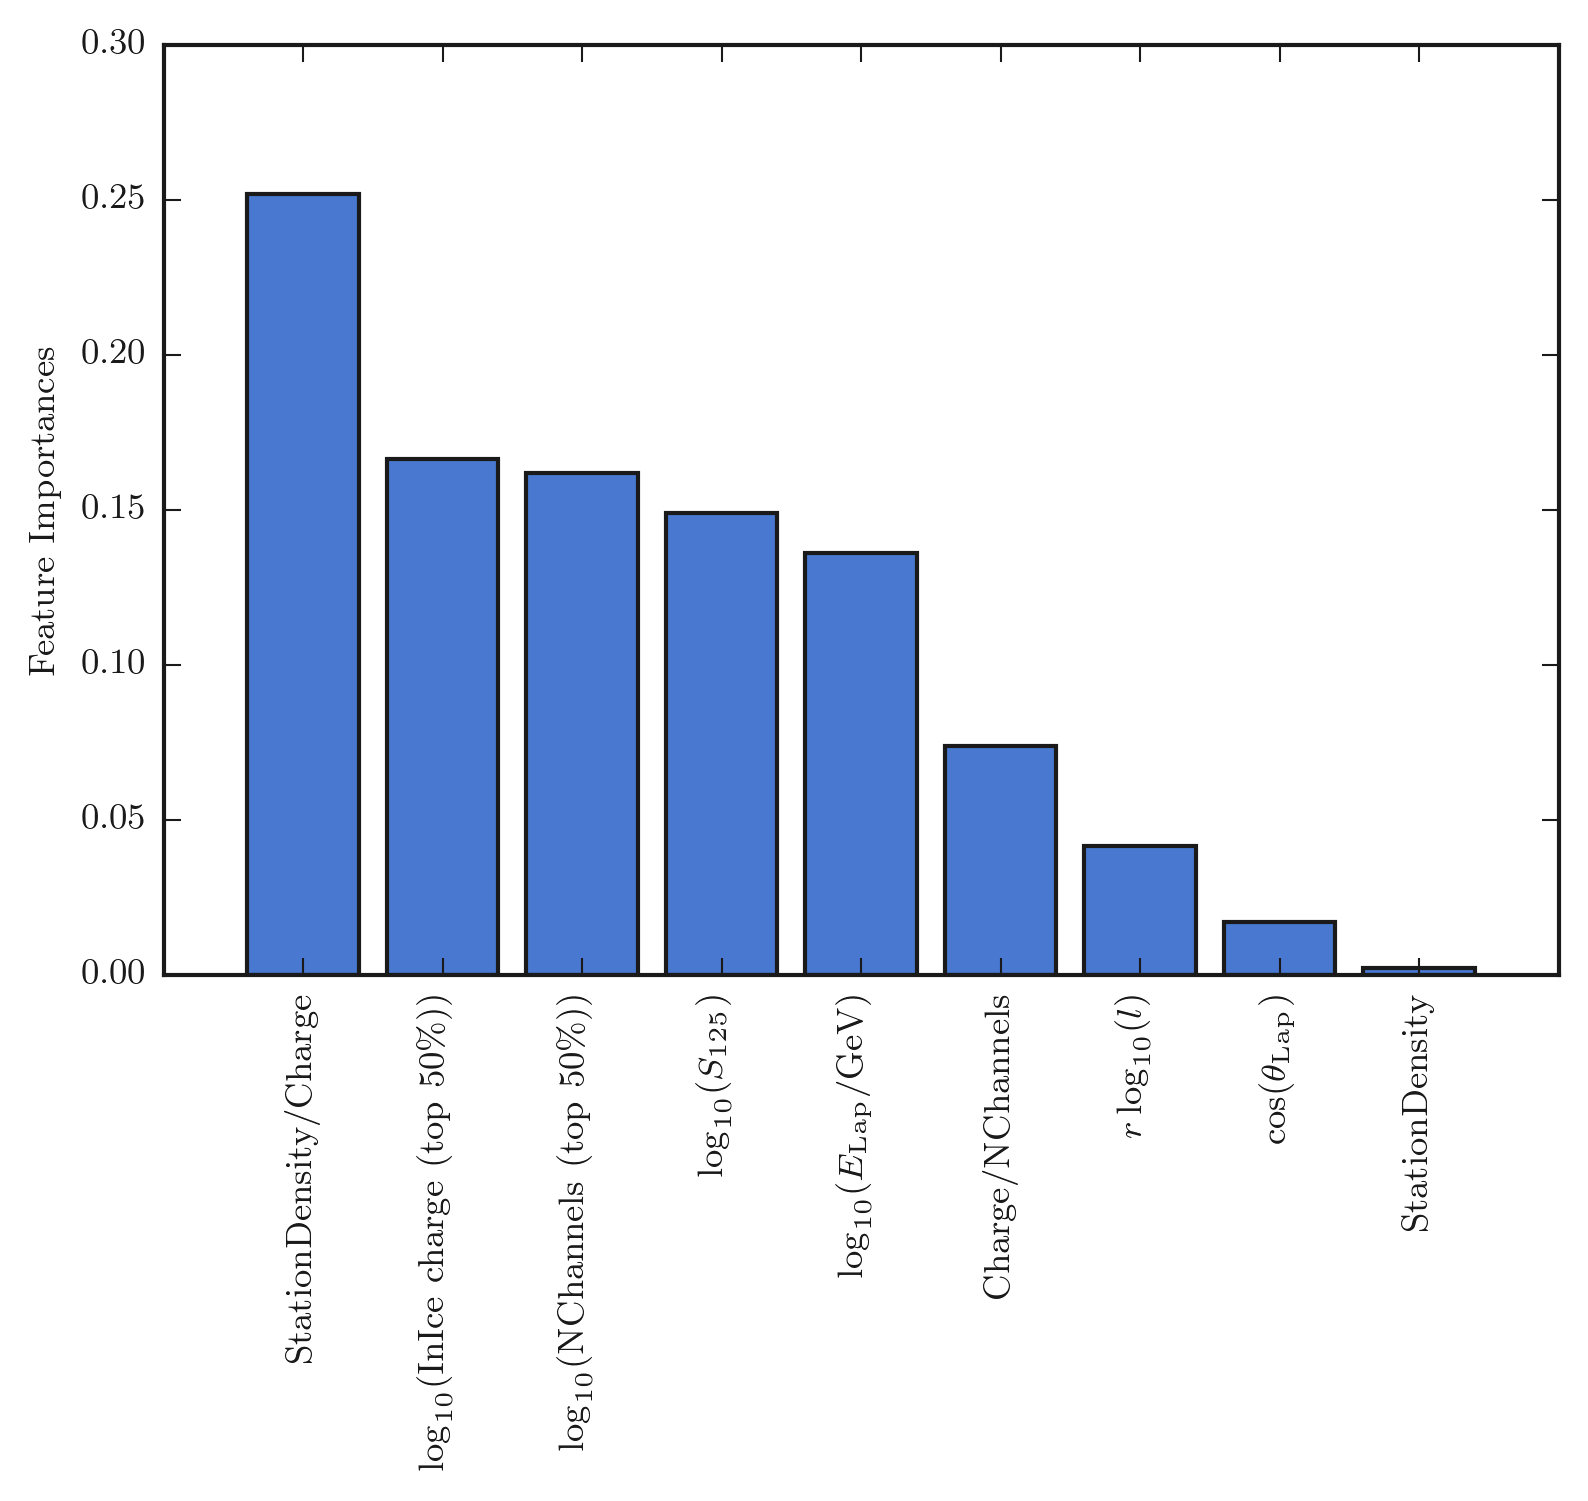

In [19]:
num_features = len(feature_list)
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
# plt.ylim([0, .40])
plt.show()

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)

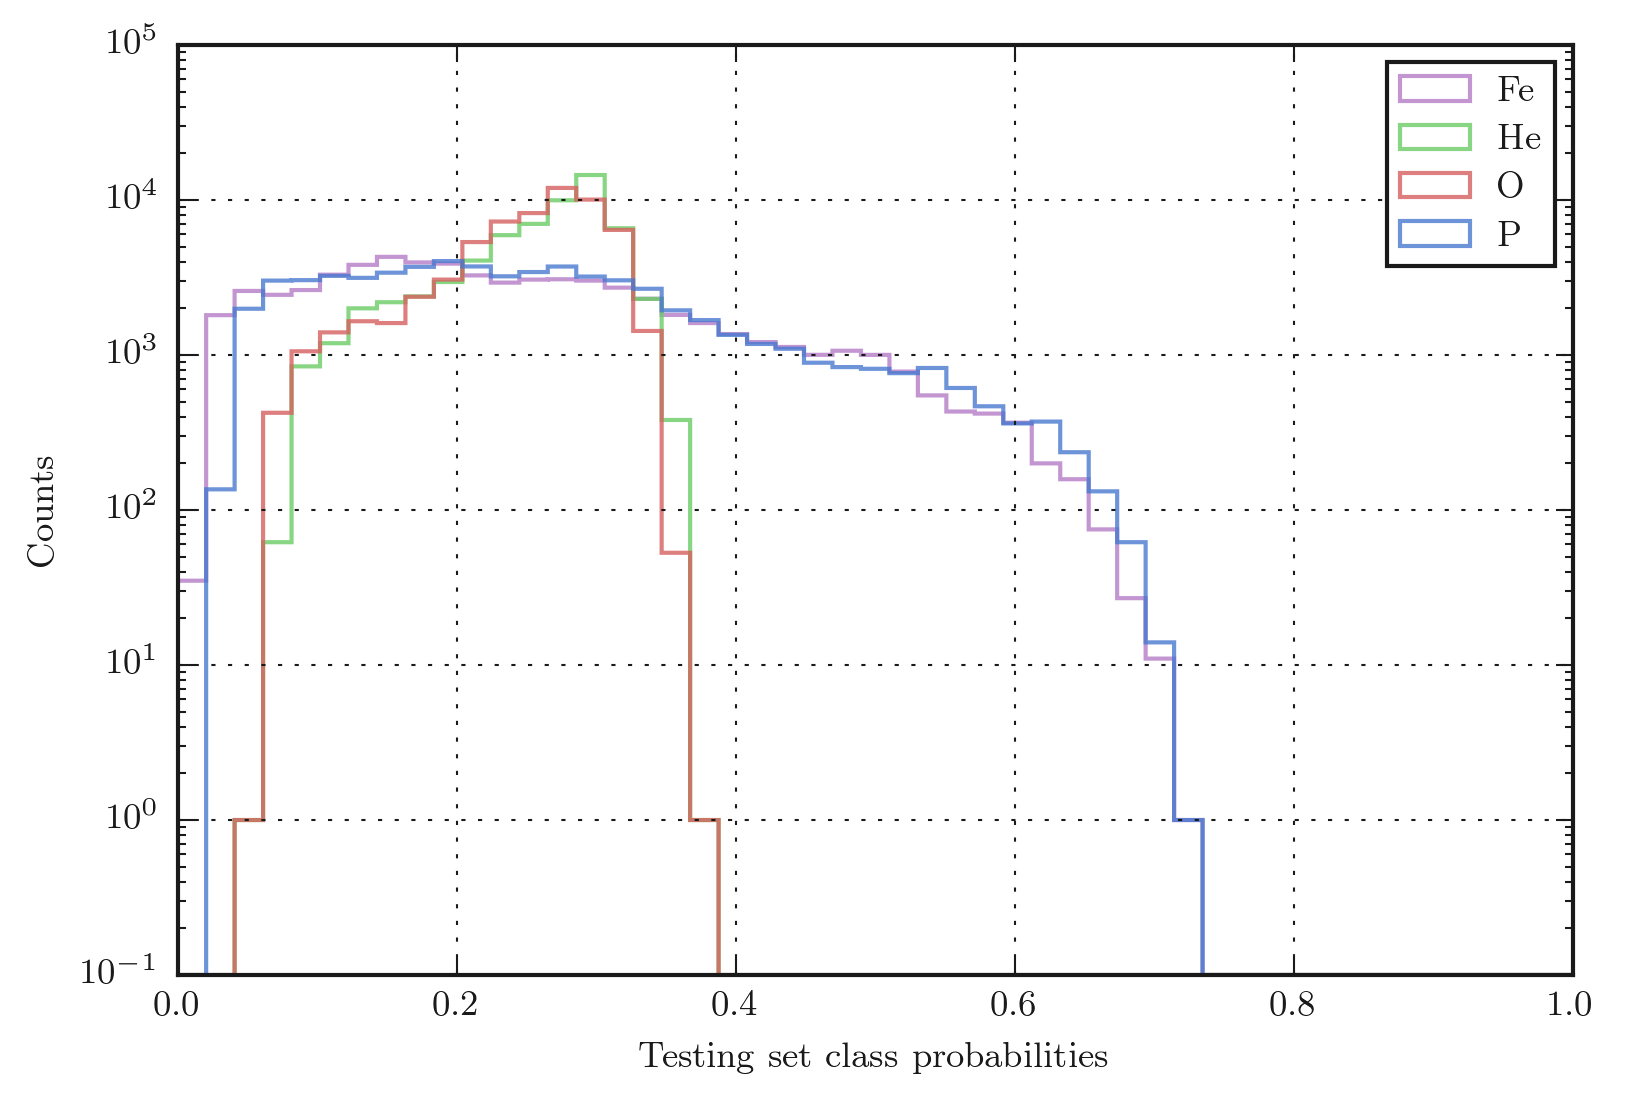

In [48]:
comp_list = ['P', 'He', 'O', 'Fe']
# test_probs = defaultdict(list)
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
for class_ in pipeline.classes_:
    composition = le.inverse_transform(class_)
    plt.hist(test_probs[:, class_], bins=np.linspace(0, 1, 50),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=True)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend()
plt.grid()
plt.show()

probs = (15883, 4)
min = 1.38011981318
max = 3.56902754108
probs = (15920, 4)
min = 1.40518894839
max = 3.5562126663
probs = (15507, 4)
min = 1.45593414673
max = 3.57278805564
probs = (15066, 4)
min = 1.50426220527
max = 3.60566706999


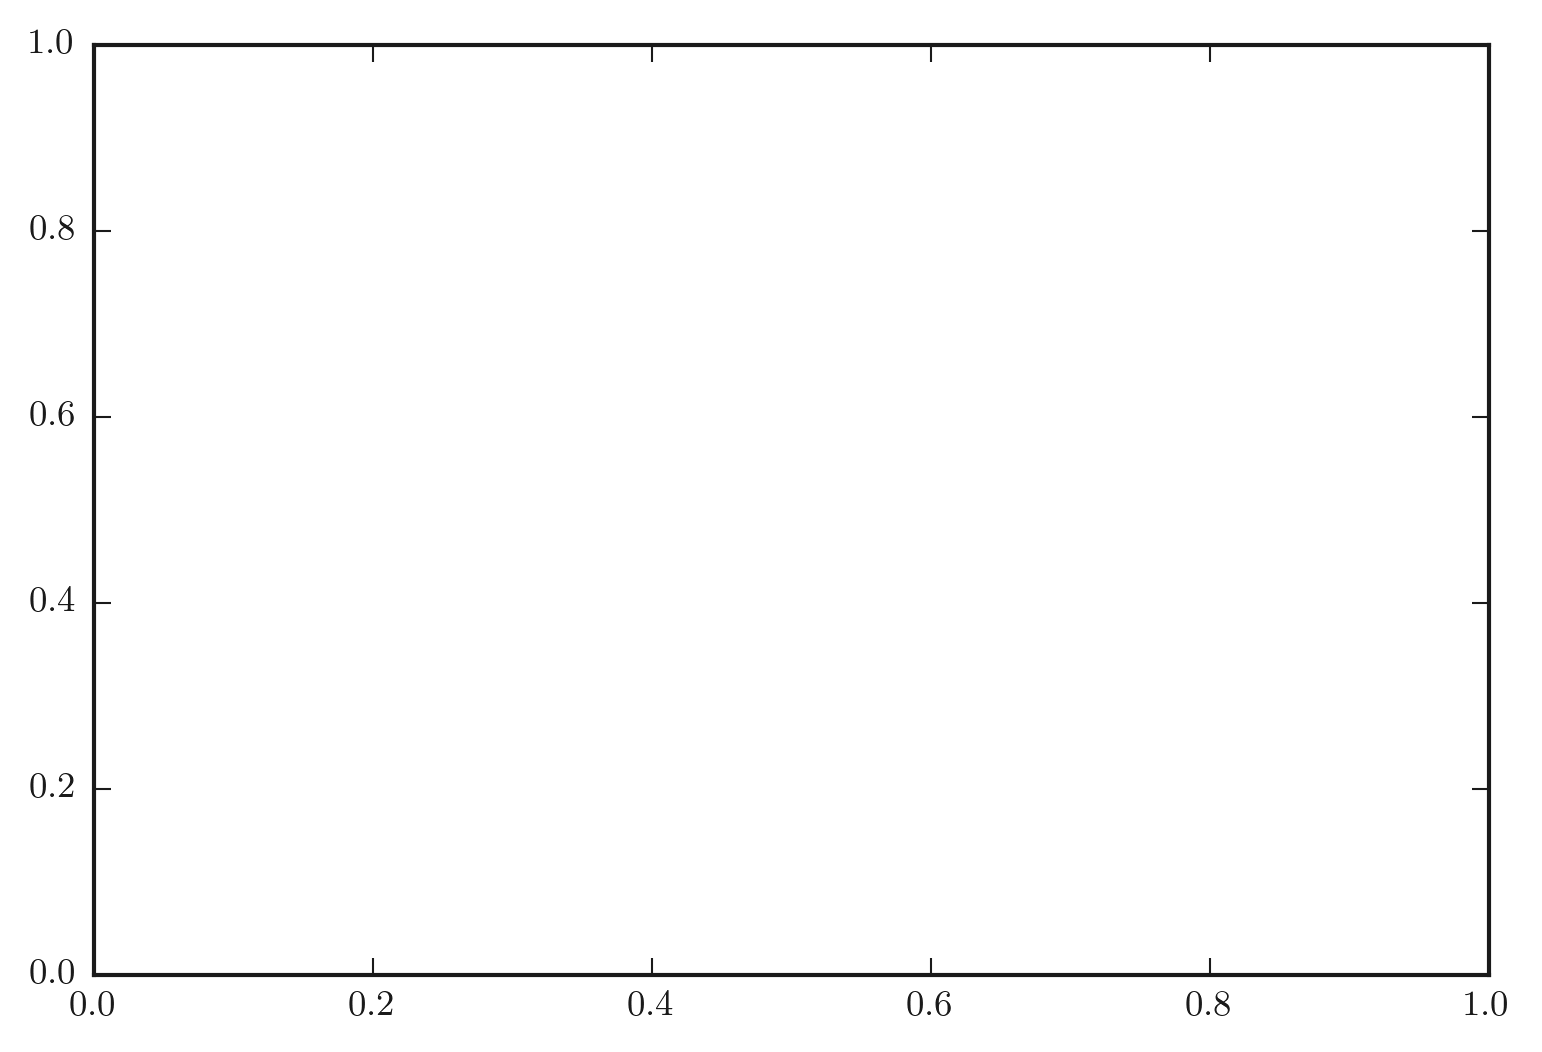

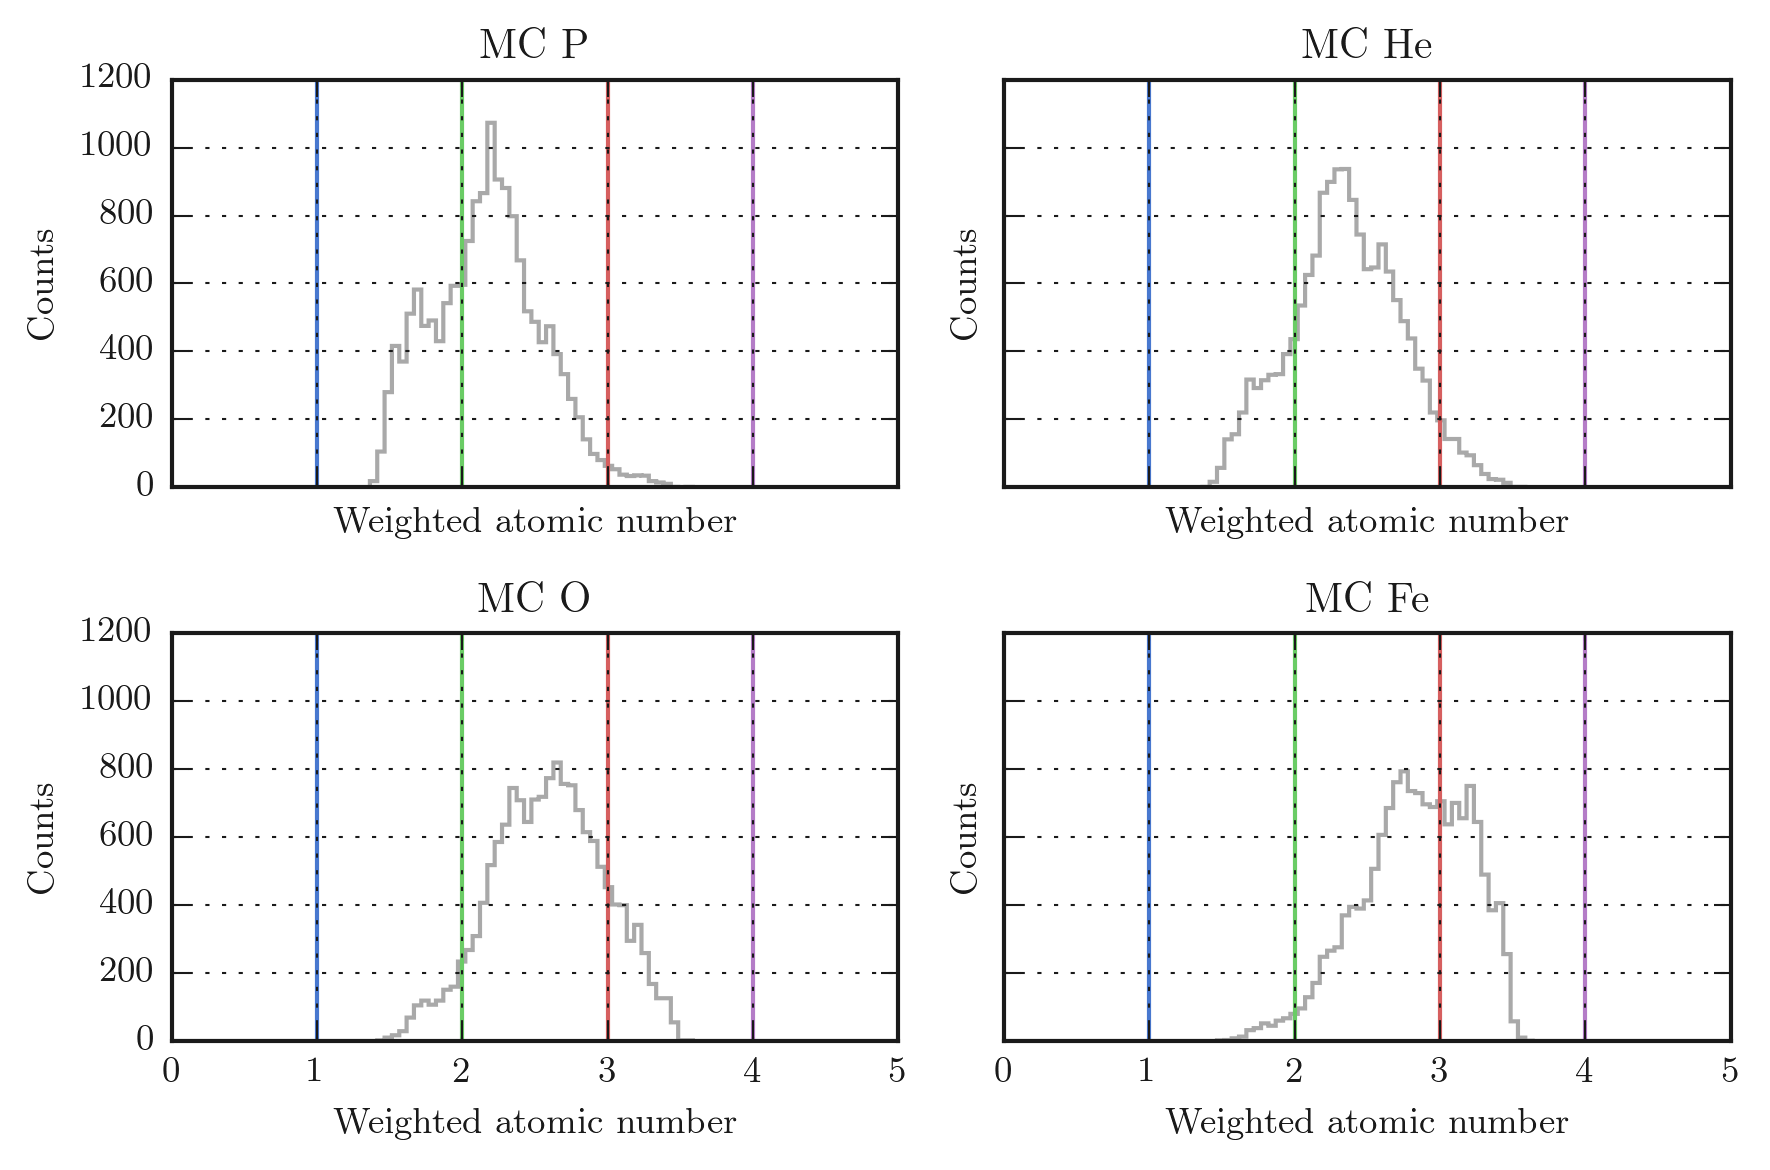

In [5]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    print('probs = {}'.format(probs.shape))
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        weighted_mass += comp.simfunctions.comp2mass(c) * probs[:, class_]
    print('min = {}'.format(min(weighted_mass)))
    print('max = {}'.format(max(weighted_mass)))
    ax.hist(weighted_mass, bins=np.linspace(0, 5, 100),
             histtype='step', label=None, color='darkgray',
             alpha=1.0, log=False)
    for c in comp_list:
        ax.axvline(comp.simfunctions.comp2mass(c), color=color_dict[c],
                   marker='None', linestyle='-')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Weighted atomic number')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

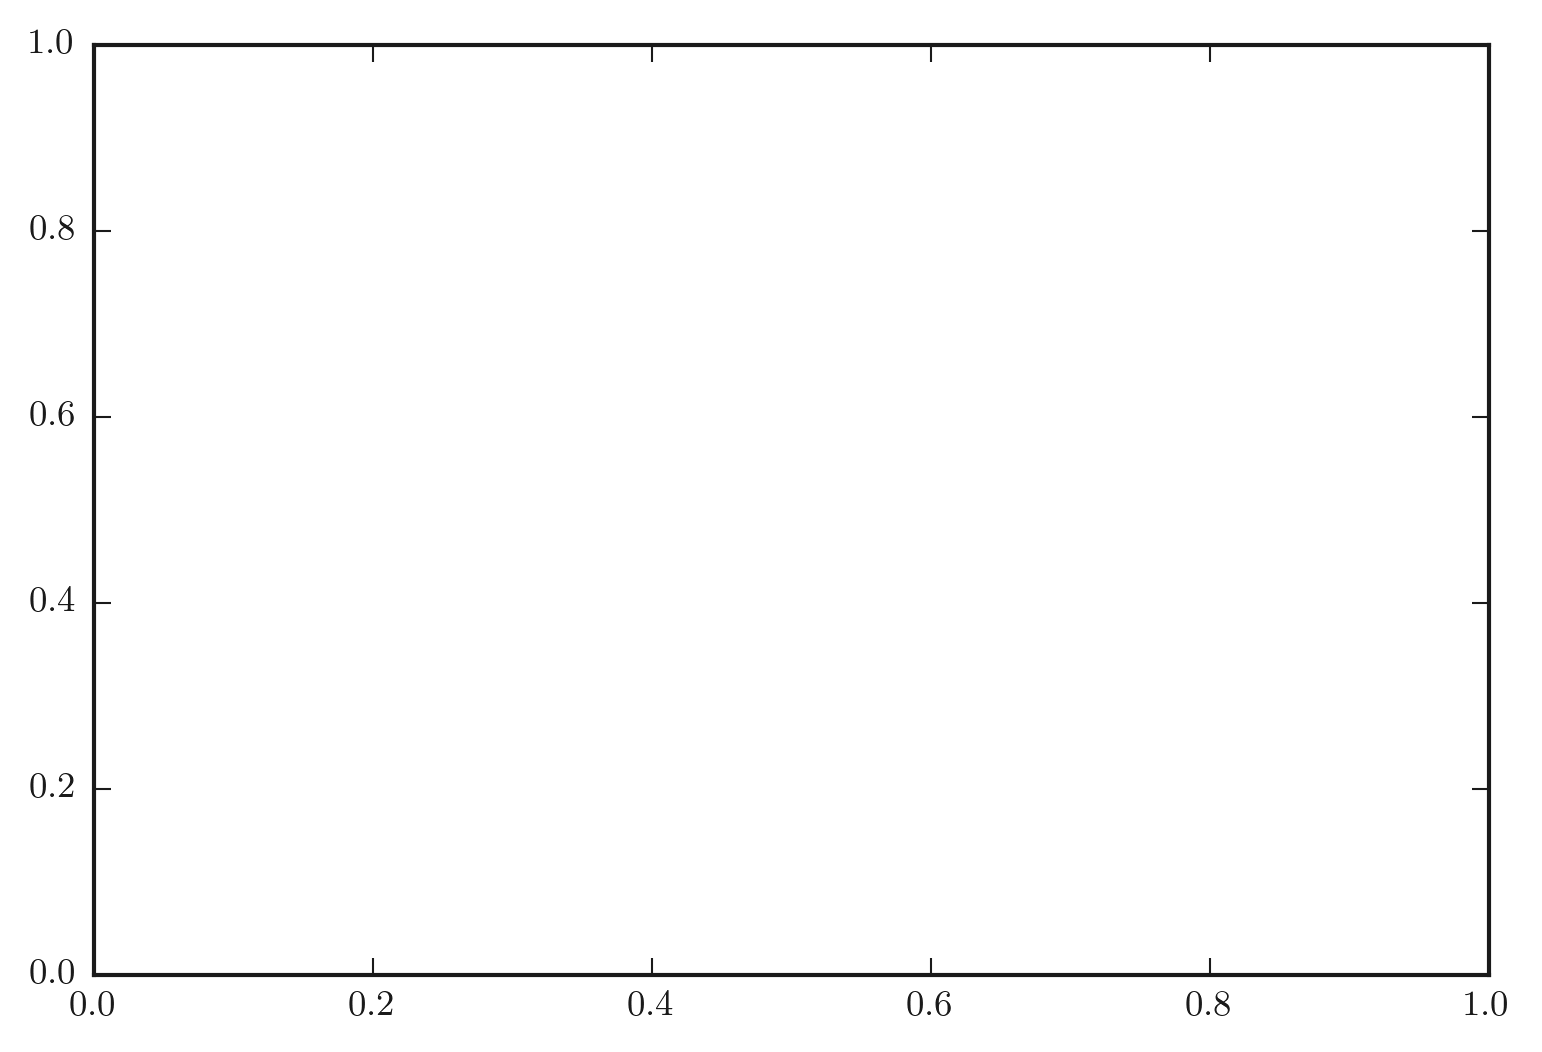

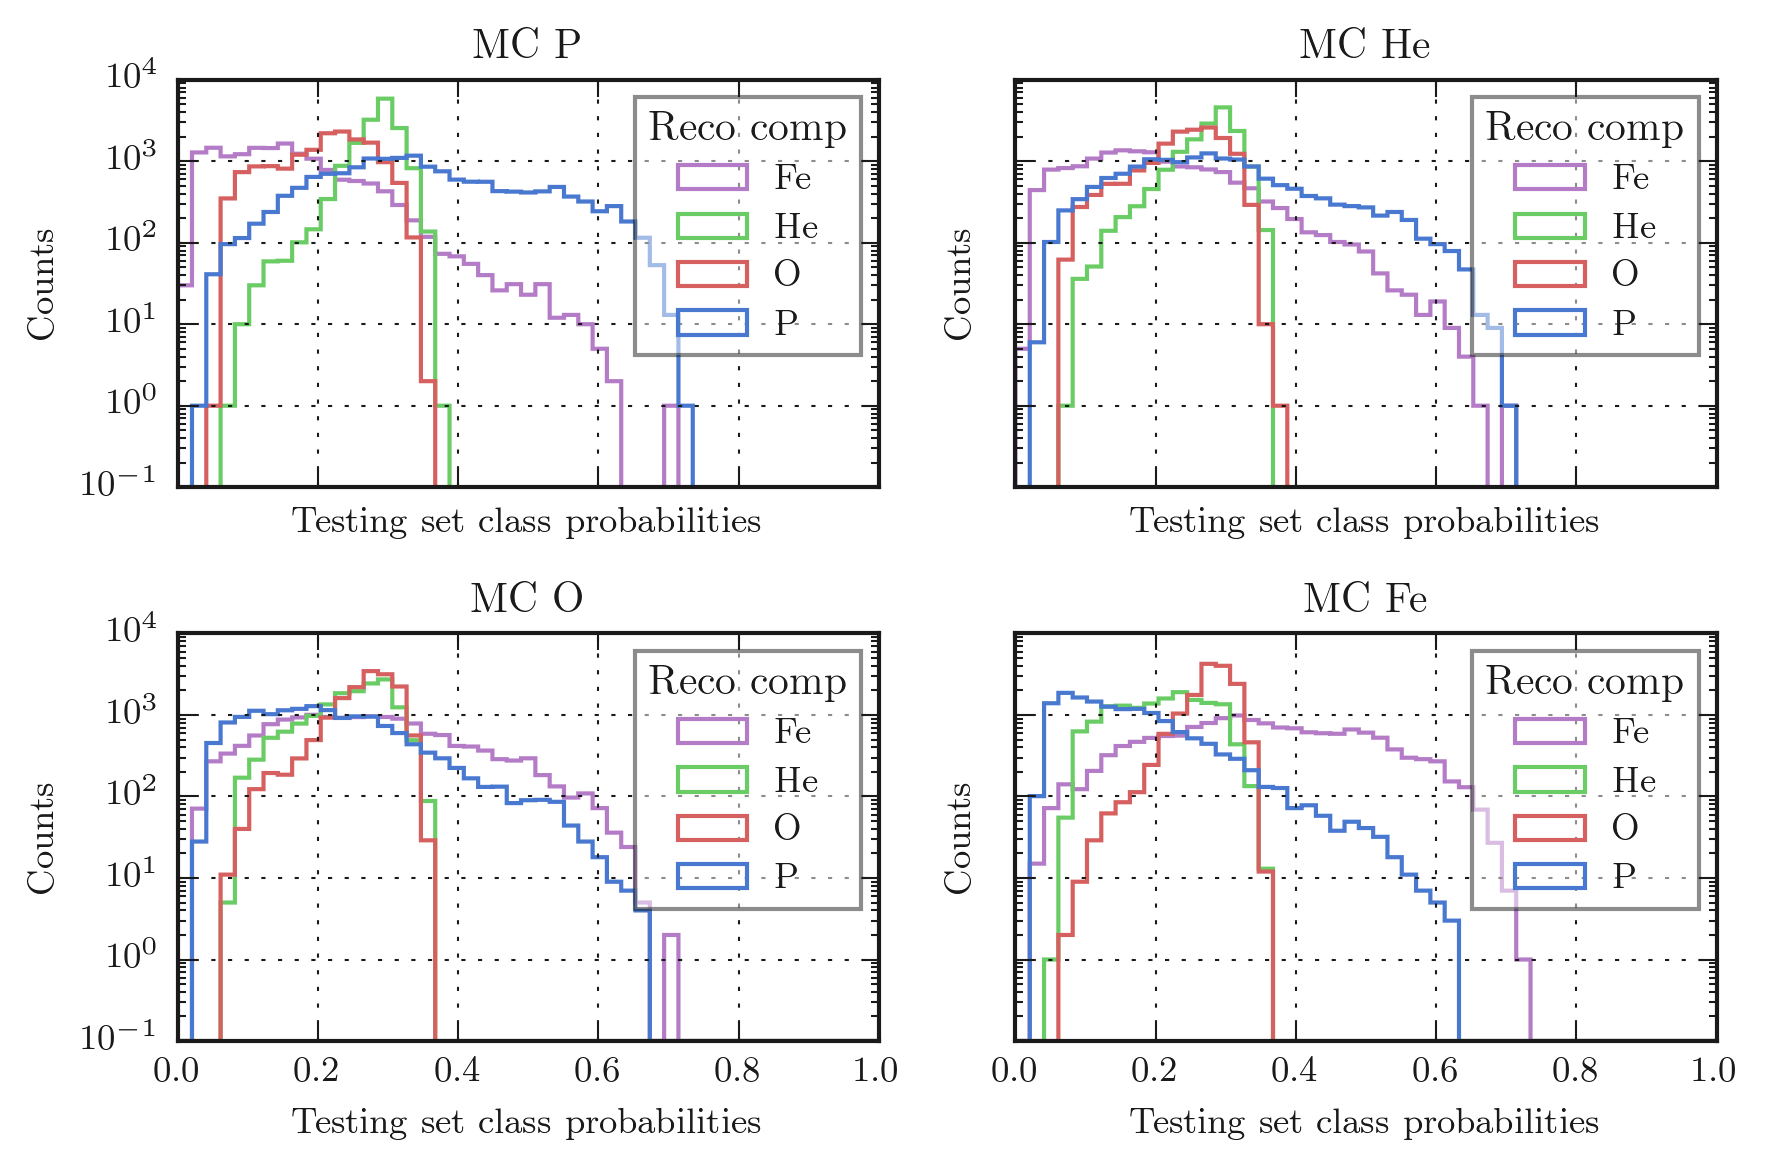

In [15]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        ax.hist(probs[:, class_], bins=np.linspace(0, 1, 50),
                 histtype='step', label=c, color=color_dict[c],
                 alpha=1.0, log=True)
    ax.legend(title='Reco comp', framealpha=0.5)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Testing set class probabilities')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

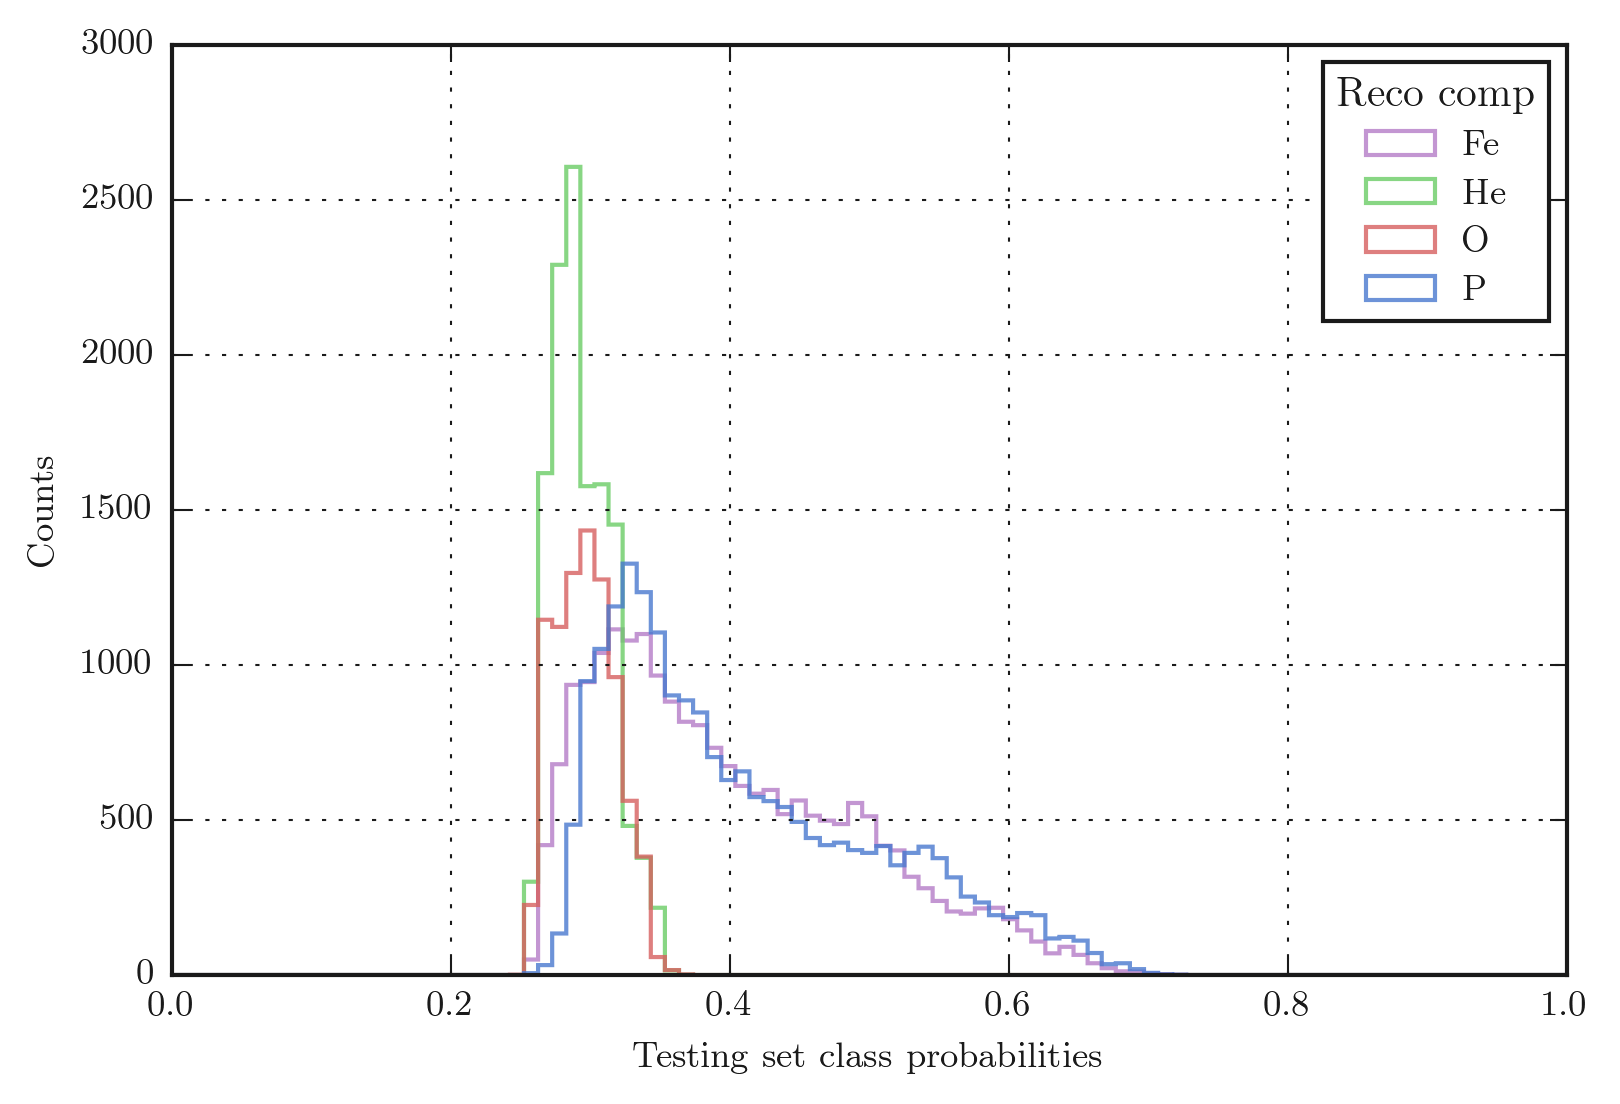

In [50]:
comp_list = np.unique(df['MC_comp'])
test_probs = defaultdict(list)
fig, ax = plt.subplots()
# test_probs = pipeline.predict_proba(X_test)
for event in pipeline.predict_proba(X_test):
    composition = le.inverse_transform(np.argmax(event))
    test_probs[composition].append(np.amax(event))
for composition in comp_list:
    plt.hist(test_probs[composition], bins=np.linspace(0, 1, 100),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=False)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend(title='Reco comp')
plt.grid()
plt.show()